<a href="https://colab.research.google.com/github/moonlovist/ML_DLA/blob/main/DLA_1D_CNN_z.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#DLA detection within Ly-alpha forests with CNNs

We use a Convolutional Neural Network (deep learning) to learn the features from the quasar spectrum of eBOSS DR16 data. The CNN  model is implemented here with Keras and a TensorFlow backend.  We use as training set, the visually classified sample of ~300,000 quasars.

---



#### Before we start, make sure to open this Colab notebook in "PlayGround Mode" (top left) and to change the Runtime type to GPU by navigating to the toolbar and clicking Runtime -> Change runtime type and then changing Hardware accelerator to GPU

---

In [1]:
import numpy as np
from astropy.io import fits
from astropy.table import Table
import os
from sklearn import preprocessing
import tensorflow as tf
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers import  BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers import MaxPool2D
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
import tensorflow.keras.backend as K
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.callbacks import TensorBoard

from sklearn.metrics import roc_curve, precision_recall_curve, accuracy_score,auc

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Deep Learning (CNN)
This section illustrates how to use a Convolutional Neural Network to estimate the DLA detection. The input of the network are now the spectra themselves without parameters. The CNN then automatically extracts the features. This is the main difference between classical and deep learning.

### Data Download and Preparation

In [3]:
#Load data
pathinData="/content/drive/My Drive/ML_DLA"

#images
X = np.load(pathinData+'/Classification_catalog_SN_6_mock_4.7.01.npy')
X = np.expand_dims(X,axis=2)
#morphological class
Y1 = np.load(pathinData+'/Classification_id_SN_6_mock_4.7.01.npy') 
Y2 = np.load(pathinData+'/Classification_z_SN_6_mock_4.7.01.npy') 
#Y = np.transpose(np.vstack((Y1,Y2)))
Y = Y2

In [ ]:
X.shape

(1947239, 400, 1)

In [ ]:
Y = Y1

In [ ]:
Y.shape

(1947239,)

In [ ]:
Y1[Y1==0].shape

(1625660,)

In [4]:
X = np.vstack((X[Y1==0][0:Y1[Y1==1].shape[0],:,:],X[Y1==1]))
Y2 = np.hstack((Y2[Y1==0][0:Y1[Y1==1].shape[0]],Y2[Y1==1]))
Y1 = np.hstack((Y1[Y1==0][0:Y1[Y1==1].shape[0]],Y1[Y1==1]))
#Y = np.transpose(np.vstack((Y1,Y2)))
Y = Y2*Y1
Y = np.round(Y,3)

In [5]:
from sklearn.utils import shuffle
X, Y = shuffle(X, Y, random_state=0)

In [6]:
# Spliting in Training and Test datasets, 4/5 of galaxies for training, 1/5 for testing
x_train = X[0:len(X)//5*3,:,:]
x_val = X[len(X)//5*3:len(X)//5*4,:,:]   
x_test = X[len(X)//5*4:,:,:]
t_train = Y[0:len(Y)//5*3]
t_val = Y[len(Y)//5*3:len(Y)//5*4]
t_test = Y[len(Y)//5*4:]
#t_train = Y[0:len(Y)//5*3,:]
#t_val = Y[len(Y)//5*3:len(Y)//5*4,:]
#t_test = Y[len(Y)//5*4,:]
print ('Y_train.shape= ', t_train.shape)   

Y_train.shape=  (385893,)


### Pre-processing of images (Normalization)

In [7]:
mu = np.median(x_train,axis=(1,2))
for i in range(0,mu.shape[0]):
    x_train[i,:,:] = x_train[i,:,:]/mu[i]
    
mu_test = np.amax(x_test,axis=(1,2))
for i in range(0,mu_test.shape[0]):
    x_test[i,:,:] = x_test[i,:,:]/mu_test[i]

mu_val = np.amax(x_val,axis=(1,2))
for i in range(0,mu_val.shape[0]):
    x_val[i,:,:] = x_val[i,:,:]/mu_val[i] 


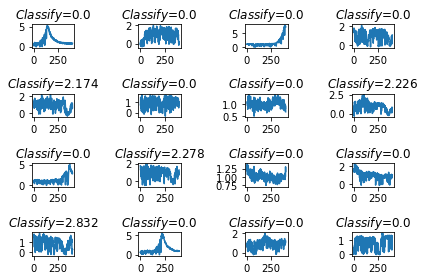

In [8]:
randomized_inds_train = np.random.permutation(len(x_train))

fig = plt.figure()


for i,j in zip(randomized_inds_train[0:16],range(16)):
  ax = fig.add_subplot(4, 4, j+1)
  im = ax.plot(x_train[i])
  plt.title('$Classify$='+str(t_train[i]))
  fig.tight_layout() 

### Model definition
The following cell defines the model architecture. There is a Convolutional part made of multiple convolutinal layers with differnet depths and filter sizes. MaxPooling are used to reduce the sizes of tensors as we go deeper into the network. Batch Normalization and Dropout are use at the training phase to reduce over fitting.

In [9]:
def custom_loss(y_true, y_pred):
    
    nboxes = y_pred.get_shape().as_list()[1]
    #print(nboxes)
    #tf.print(y_true[...,0:nboxes],y_true[...,nboxes:2*nboxes],y_true[...,2*nboxes:3*nboxes])
    #print(y_pred.shape,y_true[...,nboxes:2*nboxes].eval(),y_pred[...,nboxes:2*nboxes].eval())
    #N1 = tf.math.reduce_sum(y_true[...,0:nboxes], axis=1) + K.epsilon()
    #N2 = tf.math.reduce_sum((1-y_true[...,0:nboxes]), axis=1) + K.epsilon()
    #loss_class = -tf.math.reduce_sum(y_true[...,0:nboxes]*tf.math.log(K.clip(y_pred[...,0:nboxes], K.epsilon(), 1-K.epsilon())), axis=1)/N1
    #loss_class -= tf.math.reduce_sum((1-y_true[...,0:nboxes])*tf.math.log(K.clip(1-y_pred[...,0:nboxes], K.epsilon(), 1-K.epsilon())), axis=1)/N2

    z_true = y_true[...,0:nboxes]
    z_pred = y_pred[...,0:nboxes]
    #tf.print(z_true,z_pred)
    dz = tf.math.subtract(z_true, z_pred)
    N1 = tf.math.reduce_sum(y_true[...,0:nboxes], axis=1) + K.epsilon()
    loss_z = tf.math.reduce_sum(tf.math.square(dz), axis=1)

    #NHI_true = y_true[...,2*nboxes:3*nboxes]
    #NHI_pred = y_pred[...,2*nboxes:3*nboxes]
    #dNHI = tf.math.subtract(NHI_true, NHI_pred)
    #loss_NHI = tf.math.reduce_sum(y_true[...,0:nboxes]*tf.math.square(dNHI), axis=1)*0.01/N1
    #tf.print(loss_class,loss_z,loss_NHI)
    return loss_z



In [10]:
def accuracy_z(y_true, y_pred):
  nboxes = y_pred.get_shape().as_list()[1]
  difference = y_pred[...,0:nboxes].numpy().reshape(-1)-y_true[...,0:nboxes].numpy().reshape(-1)
  accuracy_array = difference<0.012
  accuracy_count = np.count_nonzero(accuracy_array)
  accuracy = round(accuracy_count/difference.shape[0],5)
  return accuracy

In [13]:
# CNN Ting
def CNN_Nair(img_channels, img_rows, img_cols):
    
    # some hyperparamters you can chage
    dropoutpar=0.5
    depth=16   
    nb_dense = 64
  
    inputs = layers.Input(shape=(400, 1))
    conv1 = layers.Conv1D(100, 32,strides = 3, activation='relu', padding="same")(inputs)
    pool1 = layers.MaxPooling1D(7,strides = 4)(conv1)
    conv2 = layers.Conv1D(96, 16,strides = 1, activation='relu', padding="same")(pool1)
    pool2 = layers.MaxPooling1D(6,strides = 4)(conv2)
    conv3= layers.Conv1D(96, 16,strides = 1, activation='relu', padding="same")(pool2)
    pool3 = layers.MaxPooling1D(6,strides = 4)(conv3)
    flatten1 = layers.Flatten()(pool3) 
    dense1 = layers.Dense(64,activation='relu')(flatten1)
    dense2 = layers.Dense(32,activation='relu')(dense1)
    #dense3 = layers.Dense(1,activation='softmax')(dense2)
    #dense3 = layers.Dense(1,activation='sigmoid')(dense2)
    dense3 = layers.Dense(1,activation='relu')(dense2)
    model = models.Model(inputs, dense3)

    #model=Sequential()
    #model.add(Conv2D(64, 64,1, activation='relu',padding='same',input_shape=(img_rows, img_cols, img_channels)))
    #model.add(Conv2D(64, 64,12, activation='relu',padding='same',input_shape=(img_rows, img_cols, img_channels)))
    #model.add(BatchNormalization())  ## batch normalization layer
    ## ADD LAYERS / CONVOLUTIONS HERE
    ## FROM HERE IS THE FULLY CONNECTED PART OF THE MODEL. YOU CAN ALSO CHANGE THIS
    #model.add(Flatten())
    #model.add(Dense(nb_dense, activation='relu'))
    #model.add(Dropout(dropoutpar)) 

    ## OUTPUT LAYER -- DO NOT CHANGE
    #model.add(Dense(3, kernel_initializer='uniform', activation='sigmoid'))  

    # COMPILES THE MODEL. WE USE CROSS-ENTROPY LOSS. YOU CAN CHANGE THE OPTIMIZER
    # IF NEEDED
    print("Compilation...")
    model.compile(loss=custom_loss,optimizer='SGD',metrics=[accuracy_z],run_eagerly=True)
    #model.compile(loss='binary_crossentropy',optimizer='SGD',metrics=['accuracy'])
    #model.compile(loss=tf.keras.losses.CategoricalCrossentropy,optimizer='SGD',metrics=['accuracy'])
    #model.compile(loss='categorical_crossentropy',optimizer='SGD',metrics=['accuracy'])
    print("... done!")
    print("Model Summary")
    print("===================")
    model.summary()
    return model

This cell is to delete prevois runs if needed. Only run if you want to delete the results from previous runs.

In [ ]:
RESET=True
if RESET:
  os.system("rm -r "+pathout)

NameError: ignored

Main code for training the CNN model defined previously. All outputs are stored in pathout. Change if you want to keep different models. BY default the dataset is augmented to reduce overfitting. You can turn it off be setting data_augmentation to False.

In [14]:
# train params - hardocded for simplicity - you can change them
pathout='/content/drive/My Drive/ML_DLA/model' #output folder to store the results
model_name = '/cnn_SN_6_z'  #name of the final model which is saved in pathout

LOAD_MODEL=False

batch_size = 100
nb_epoch = 10  #number of iterations for training - Can be changed
data_augmentation = False # if set to True the data will be augmented at every iteration
# input image dimensions
img_rows, img_cols = x_train.shape[1:3]
img_channels = 1

#Avoid more iterations once convergence
patience_par=10
earlystopping = EarlyStopping(monitor='val_loss',patience = patience_par,verbose=0,mode='auto' )
modelcheckpoint = ModelCheckpoint(pathout+model_name+"_best.hd5",monitor='val_loss',verbose=0,save_best_only=True)
tensorboard = TensorBoard(log_dir=pathout)

#build model
#cnn=CNN_Nair(img_channels, img_rows, img_cols)
cnn=CNN_Nair(img_channels, img_rows, img_cols)
if LOAD_MODEL:
  cnn.load_weights(pathout+model_name+'.hd5')


if not data_augmentation:
  print('Not using data augmentation.')
  history = cnn.fit(x_train, t_train,
                            batch_size=batch_size,
                            epochs=nb_epoch,
                            validation_data=(x_val, t_val),
                            shuffle=True,
                            callbacks=[earlystopping, modelcheckpoint,tensorboard])
else:
  print('Using real-time data augmentation.')

  # this will do preprocessing and realtime data augmentation. FEEL FREE TO
  # CHANGE THE PARAMETERS AND SEE THE EFFECTS
  datagen = ImageDataGenerator(
            featurewise_center=False, 
            samplewise_center=False, 
            featurewise_std_normalization=False, 
            samplewise_std_normalization=False,
            zca_whitening=False, 
            rotation_range=0,
            width_shift_range=0.1,  
            height_shift_range=0.1, 
            horizontal_flip=True,
            vertical_flip=True,
            zoom_range=False)  

        
  datagen.fit(x_train)
        
  history = cnn.fit_generator(
                    datagen.flow(x_train, t_train, batch_size=batch_size),
                    steps_per_epoch=batch_size,
                    epochs=nb_epoch,
                    validation_data=(x_val, t_val),
                    callbacks=[modelcheckpoint,tensorboard]#[ earlystopping, modelcheckpoint,tensorboard]
                )



print("Saving model...")
cnn.save_weights(pathout+model_name+".hd5",overwrite=True)
    
        


Compilation...
... done!
Model Summary
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 400, 1)]          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 134, 100)          3300      
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 32, 100)           0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 32, 96)            153696    
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 7, 96)             0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 7, 96)             147552    
_________________________________________________________________
max_pooling1d_5 (Max

Text(0, 0.5, 'Loss')

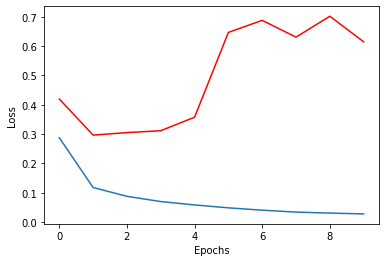

In [15]:
plot(history.history['loss'])
plot(history.history['val_loss'],color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')

In [16]:
print("Predicting...")
print("====================")
LOAD_MODEL=False
if LOAD_MODEL:
  cnn = tf.keras.models.load_model(pathout+model_name+".hd5")

Y_pred_DL = cnn.predict(x_test)


Predicting...


In [17]:
def histo(x, cut=None, range=None, bins=50, alpha=1, clear=True, color='blue', xlab=None, text=None, datarange=None, grd=True, loc='best'):
        if cut is None:
                newx = x
        else:
                newx = x[cut]
        if xlab: plt.xlabel(xlab)
        lab = ' N: '+str(len(newx))+'\n mean: {0:.3g}'.format(np.mean(newx))+'\n rms: {0:.3g}'.format(np.std(newx))
        if text is not None: lab = text+'\n'+lab
        truc=plt.hist(newx, range=range, bins=bins, alpha=alpha, color=color, label=lab)
        plt.legend(loc=loc)
        if grd: plt.grid()
        return np.array([len(newx), np.mean(newx), np.std(newx)])

array([ 1.28634000e+05, -2.58000769e-01,  7.42341753e-01])

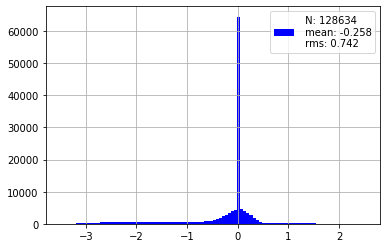

In [20]:
histo(Y_pred_DL.reshape(-1)-t_test,bins=100)

### Bad classifications of CNNs

In [ ]:
Y_pred_DL 

array([[2.413773 ],
       [2.5401962],
       [2.6424744],
       ...,
       [0.       ],
       [2.3487802],
       [0.       ]], dtype=float32)

In [ ]:
Y_pre_DL.shape

In [ ]:
t_test

array([2.683, 2.549, 2.642, ..., 0.   , 2.493, 0.   ])

In [ ]:
plt.hist(Y_pred_DL - t_test)

In [ ]:
his.shape